# Coupled higgs equation 
$$
u_{tt} - u_{xx} + |u|^2 u - 2uv = 0
$$
$$
v_{tt} + v_{xx} - (\left| u \right|^2)_{xx} = 0
$$

where, $ u(x,t) $ represents a complex nucleon field and $ v(x,t) $ represents a real scalar meson field. The coupled Higgs field Equation describes a system of conserved scalar nucleon interaction with a neutral scalar meson.

solutions 

$$
u_1(x, t) = ir e^{ir(\omega x + t)} \sqrt{1 + \omega^2} \tanh\left(\frac{r(k + x + \omega t)}{\sqrt{2}}\right)
$$
$$
v_1(x, t) = r^2 \tanh^2\left(\frac{r(k + x + \omega t)}{\sqrt{2}}\right)
$$

for $t = 0$

$$
u_1(x, 0) = ir e^{ir \omega x} \sqrt{1 + \omega^2} \tanh\left(\frac{r(k + x)}{\sqrt{2}}\right)
$$
$$
v_1(x, 0) = r^2 \tanh^2\left(\frac{r(k + x)}{\sqrt{2}}\right)
$$

where 
$k = 4, \omega = 5 , \alpha = 2, c = 2, r = 2$


In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
import os
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [2]:
# Activation function class
class SinActv(nn.Module):
    def forward(self, input_):
        return torch.sin(input_)

# Base class for shared functionalities
class BaseNN(nn.Module):
    def __init__(self):
        super(BaseNN, self).__init__()

    def _make_layers(self, in_features, out_features, num_layers, activation):
        layers = [nn.Linear(in_features, out_features), activation()]
        for _ in range(1, num_layers):
            layers += [nn.Linear(out_features, out_features), activation()]
        return nn.Sequential(*layers)

# Model for U1
class ModelU1(BaseNN):
    def __init__(self, input_dim=2, shared_units=128, branch_units=32, output_dim=1, shared_layers=4, branch_layers=1, activation=SinActv):
        super(ModelU1, self).__init__()
        self.shared_layers = self._make_layers(input_dim, shared_units, shared_layers, activation)
        
        # Branch for real part
        self.branch_real = self._make_layers(shared_units, branch_units, branch_layers, activation)
        self.final_real = nn.Linear(branch_units, output_dim)
        
        # Branch for imaginary part
        self.branch_imag = self._make_layers(shared_units, branch_units, branch_layers, activation)
        self.final_imag = nn.Linear(branch_units, output_dim)

    def forward(self, x):
        shared_output = self.shared_layers(x)
        u_real = self.final_real(self.branch_real(shared_output))
        u_imag = self.final_imag(self.branch_imag(shared_output))
        return u_real, u_imag

# Model for V1
class ModelV1(BaseNN):
    def __init__(self, input_dim=2, units=128, output_dim=1, layers=5, activation=nn.Tanh):
        super(ModelV1, self).__init__()
        self.layers = self._make_layers(input_dim, units, layers, activation)
        self.final = nn.Linear(units, output_dim)

    def forward(self, x):
        return self.final(self.layers(x))

In [3]:
def grad(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def laplacian(field, x, t):
    field_x = grad(field, x)
    field_xx = grad(field_x, x)
    field_t = grad(field, t)
    field_tt = grad(field_t, t)
    return field_xx, field_tt

# Define the ODE system for the Coupled Higgs field equations
def coupled_higgs(u_real, u_imag, v, x, t):
    u_r_xx, u_r_tt = laplacian(u_real, x, t)
    u_i_xx, u_i_tt = laplacian(u_imag, x, t)
    v_xx, v_tt = laplacian(v, x, t)

    u_abs = u_real**2 + u_imag**2
    u_abs_xx, u_abs_tt = laplacian(u_abs, x, t)

    # Calculate the field equations
    du_eq_r = u_r_tt - u_r_xx + u_abs * u_real - 2 * u_real * v
    du_eq_i = u_i_tt - u_i_xx + u_abs * u_imag - 2 * u_imag * v
    dv_eq = v_tt + v_xx - u_abs_xx
    
    return du_eq_r, du_eq_i, dv_eq

# Function to calculate the real part of u1
def real_u1(x, t, k, omega, r):
    return np.real(1j * r * np.exp(1j * r * (omega * x + t)) * np.sqrt(1 + omega**2) *
                   np.tanh( (r * (k + x + omega * t)) / np.sqrt(2) ) )

def imag_u1(x, t, k, omega, r):
    return np.imag(1j * r * np.exp(1j * r * (omega * x + t)) * np.sqrt(1 + omega**2) *
                   np.tanh((r * (k + x + omega * t)) / np.sqrt(2) ) )
    
def real_v1(x, t, k, omega, r):
    return (r * np.tanh((r * (k + x + omega * t)) / np.sqrt(2)) )**2

def compute_analytical_boundary_loss(model_u1, model_v1, x_boundary, t_boundary, mse_cost_function, k, omega, r):
    x_t_boundary = Variable(torch.from_numpy(np.hstack([x_boundary, t_boundary])).float(), requires_grad=False).to(device)
    
    pred_u_r, pred_u_i = model_u1(x_t_boundary)
    pred_v = model_v1(x_t_boundary)

    real_u1_val = torch.tensor(real_u1(x_boundary, t_boundary, k, omega, r), device=device).float().view(-1, 1)
    imag_u1_val = torch.tensor(imag_u1(x_boundary, t_boundary, k, omega, r), device=device).float().view(-1, 1)
    real_v1_val = torch.tensor(real_v1(x_boundary, t_boundary, k, omega, r), device=device).float().view(-1, 1)
 
    boundary_loss_ur = mse_cost_function(pred_u_r, real_u1_val)
    boundary_loss_ui = mse_cost_function(pred_u_i, imag_u1_val)
    boundary_loss_v = mse_cost_function(pred_v, real_v1_val)
    
    boundary_loss_u = torch.mean(boundary_loss_ur ** 2 + boundary_loss_ui ** 2)
    boundary_loss_v = boundary_loss_v ** 2
    
    return boundary_loss_u, boundary_loss_v

def compute_physics_loss(model_u1, model_v1, x, t, mse_cost_function):
    #x_t = Variable(torch.from_numpy(np.hstack([x, t])).float(), requires_grad=True).to(device)
    x_t = torch.cat([x, t], dim=1) 
    pred_u_r, pred_u_i = model_u1(x_t)
    pred_v = model_v1(x_t)
    
    du_eq_r, du_eq_i, dv_eq = coupled_higgs(pred_u_r, pred_u_i, pred_v, x, t)
    loss_pde_u = torch.mean(du_eq_r**2 + du_eq_i**2)  
    loss_pde_v = torch.mean(dv_eq**2)
    
    return loss_pde_u, loss_pde_v

In [4]:
# Check if CUDA is available and set the default device
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

model_u1 = ModelU1().to(device)
model_v1 = ModelV1().to(device)

num_epochs = 100000  # Number of training epochs
lr = 1e-3          # Learning rate
num_samples = 1000 # Number of samples for training
r = 1.1
omega = 5
k = 0.5

optimizer_u1 = Adam(model_u1.parameters(), lr=lr)
optimizer_v1 = Adam(model_v1.parameters(), lr=lr)
mse_cost_function = torch.nn.MSELoss()
model_save_path = 'model_weights_testing_CHIGGS'
os.makedirs(model_save_path, exist_ok=True)
losses = []

CUDA is available! Training on GPU.


In [5]:
# Training loop
for epoch in tqdm(range(num_epochs),
                  desc='Progress:',  # Empty description
                  leave=False,  # Do not leave the progress bar when done
                  ncols=75,  # Width of the progress bar
                  mininterval=0.1,
                  bar_format='{l_bar}{bar}|{remaining}',  # Only show the bar without any counters
                  colour='blue'):
    x_n = (torch.rand(num_samples, 1) * 1).to(device)  # x in range [-5, -3]
    t_n = (torch.rand(num_samples, 1) * 1).to(device)   
    x_n.requires_grad = True
    t_n.requires_grad = True
    x_bc_x0 = np.zeros((num_samples, 1))
    t_bc_x0 = np.random.uniform(0, 1, (num_samples, 1))
    x_bc_x1 = np.ones((num_samples, 1))
    t_bc_x1 = np.random.uniform(0, 1, (num_samples, 1))
    x_bc_t0 = np.random.uniform(0, 1, (num_samples, 1))
    t_bc_t0 = np.zeros((num_samples, 1))
    x_bc_t1 = np.random.uniform(0, 1, (num_samples, 1))
    t_bc_t1 = np.ones((num_samples, 1))

    x_dom = np.random.uniform(0, 1, (num_samples, 1))
    t_dom = np.random.uniform(0, 1, (num_samples, 1))
    
    optimizer_u1.zero_grad()
    optimizer_v1.zero_grad()

    physics_loss_u, physics_loss_v = compute_physics_loss(model_u1, model_v1, x_n, t_n, mse_cost_function)
    boundary_loss_u_x0, boundary_loss_v_x0 = compute_analytical_boundary_loss(model_u1, model_v1, x_bc_x0, t_bc_x0, mse_cost_function, k, omega, r)
    boundary_loss_u_x1, boundary_loss_v_x1 = compute_analytical_boundary_loss(model_u1, model_v1, x_bc_x1, t_bc_x1, mse_cost_function, k, omega, r)
    boundary_loss_u_t0, boundary_loss_v_t0 = compute_analytical_boundary_loss(model_u1, model_v1, x_bc_t0, t_bc_t0, mse_cost_function, k, omega, r)
    boundary_loss_u_t1, boundary_loss_v_t1 = compute_analytical_boundary_loss(model_u1, model_v1, x_bc_t1, t_bc_t1, mse_cost_function, k, omega, r)
    domain_loss_u_t, domain_loss_v_t = compute_analytical_boundary_loss(model_u1, model_v1, x_dom, t_dom, mse_cost_function, k, omega, r)
    
    # Total loss 
    loss_u = physics_loss_u + boundary_loss_u_x0 + boundary_loss_u_x1 + boundary_loss_u_t0 + boundary_loss_u_t1 + domain_loss_u_t
    loss_v = physics_loss_v + boundary_loss_v_x0 + boundary_loss_v_x1 + boundary_loss_v_t0 + boundary_loss_v_t1 + domain_loss_v_t

    total_loss = loss_u + loss_v 
    total_loss.backward()
    optimizer_u1.step()
    optimizer_v1.step()
    
    # Print loss every few epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss U: {loss_u.item()}, Loss V: {loss_v.item()}')
        model_u1_filename = os.path.join(model_save_path, f'C_HIGGS_U1_epoch_{epoch}.pth')
        torch.save(model_u1.state_dict(), model_u1_filename)
        
        model_v1_filename = os.path.join(model_save_path, f'C_HIGGS_V1_epoch_{epoch}.pth')
        torch.save(model_v1.state_dict(), model_v1_filename)
        
        df_losses = pd.DataFrame(losses)
        csv_file_path = 'loss_data/C_HIGGS_training_losses.csv'
        df_losses.to_csv(csv_file_path, index=False)
    
    if total_loss.item() < 0.01:
        print(f'Stopping early at epoch {epoch} due to reaching target loss.')
        break
    
    losses.append({
        'Epoch': epoch,
        'Loss U': loss_u.item(),
        'Loss V': loss_v.item(),
        'Total Loss': total_loss.item(),
        'Physics Loss': physics_loss_u.item() + physics_loss_v.item(),
        'Boundary Loss U': boundary_loss_u_x0.item() + boundary_loss_u_x1.item() + boundary_loss_u_t0.item() + boundary_loss_u_t1.item(),
        'Boundary Loss V': boundary_loss_v_x0.item() + boundary_loss_v_x1.item() + boundary_loss_v_t0.item() + boundary_loss_v_t1.item(),
        'Domain Loss U': domain_loss_u_t.item(),
        'Domain Loss V': domain_loss_v_t.item()
    })

df_losses = pd.DataFrame(losses)
csv_file_path = 'loss_data/C_HIGGS_training_losses.csv'
df_losses.to_csv(csv_file_path, index=False)

Progress::   0%|                                                   |5:39:36

Epoch 0, Loss U: 2043.76123046875, Loss V: 5.111201286315918


Progress::   1%|▌                                                  |5:40:48

Epoch 1000, Loss U: 553.0388793945312, Loss V: 60.60041809082031


Progress::   2%|█                                                  |5:44:23

Epoch 2000, Loss U: 767.6806030273438, Loss V: 46.93668746948242


Progress::   3%|█▌                                                 |5:49:03

Epoch 3000, Loss U: 494.2436828613281, Loss V: 30.718929290771484


Progress::   4%|██                                                 |5:53:21

Epoch 4000, Loss U: 492.982666015625, Loss V: 27.428203582763672


Progress::   5%|██▌                                                |5:59:26

Epoch 5000, Loss U: 495.7347717285156, Loss V: 50.65404510498047


Progress::   6%|███                                                |6:00:09

Epoch 6000, Loss U: 486.1402282714844, Loss V: 67.96528625488281


Progress::   7%|███▌                                               |9:47:07

Epoch 7000, Loss U: 464.9169616699219, Loss V: 33.67681121826172


Progress::   8%|████                                              |17:36:58

Epoch 8000, Loss U: 468.6413269042969, Loss V: 45.47181701660156


Progress::   9%|████▌                                              |6:20:55

Epoch 9000, Loss U: 472.7316589355469, Loss V: 23.43439483642578


Progress::  10%|█████                                              |9:52:36

Epoch 10000, Loss U: 468.38262939453125, Loss V: 70.02308654785156


Progress::  11%|█████▌                                             |4:56:19

Epoch 11000, Loss U: 492.2431640625, Loss V: 30.272762298583984


Progress::  12%|██████                                             |4:49:07

Epoch 12000, Loss U: 471.41534423828125, Loss V: 25.357986450195312


Progress::  13%|██████▋                                            |4:46:26

Epoch 13000, Loss U: 458.87579345703125, Loss V: 32.153076171875


Progress::  14%|███████▏                                           |4:41:55

Epoch 14000, Loss U: 475.87847900390625, Loss V: 21.88290023803711


Progress::  15%|███████▋                                           |4:40:23

Epoch 15000, Loss U: 468.0882568359375, Loss V: 38.58548355102539


Progress::  16%|████████▏                                          |4:35:52

Epoch 16000, Loss U: 449.22808837890625, Loss V: 21.297529220581055


Progress::  17%|████████▋                                          |4:33:49

Epoch 17000, Loss U: 461.63079833984375, Loss V: 104.4644775390625


Progress::  18%|█████████▏                                         |4:31:00

Epoch 18000, Loss U: 471.43994140625, Loss V: 31.876224517822266


Progress::  19%|█████████▋                                         |4:27:16

Epoch 19000, Loss U: 454.7466125488281, Loss V: 20.21822738647461


Progress::  20%|██████████▏                                        |4:24:00

Epoch 20000, Loss U: 462.11993408203125, Loss V: 27.794017791748047


Progress::  21%|██████████▋                                        |4:21:36

Epoch 21000, Loss U: 463.50628662109375, Loss V: 25.39463233947754


Progress::  22%|███████████▏                                       |4:17:17

Epoch 22000, Loss U: 477.7984619140625, Loss V: 37.18235778808594


Progress::  23%|███████████▋                                       |4:15:12

Epoch 23000, Loss U: 460.8184509277344, Loss V: 26.059011459350586


Progress::  24%|████████████▏                                      |4:10:43

Epoch 24000, Loss U: 448.5426025390625, Loss V: 37.363311767578125


Progress::  25%|████████████▊                                      |4:06:53

Epoch 25000, Loss U: 459.8583068847656, Loss V: 18.924415588378906


Progress::  26%|█████████████▎                                     |4:02:33

Epoch 26000, Loss U: 475.34906005859375, Loss V: 54.674285888671875


Progress::  27%|█████████████▊                                     |4:00:02

Epoch 27000, Loss U: 460.54888916015625, Loss V: 20.569255828857422


Progress::  28%|██████████████▎                                    |3:57:53

Epoch 28000, Loss U: 473.2608337402344, Loss V: 53.783775329589844


Progress::  29%|██████████████▊                                    |3:53:44

Epoch 29000, Loss U: 452.9119873046875, Loss V: 23.975093841552734


Progress::  30%|███████████████▎                                   |3:49:38

Epoch 30000, Loss U: 467.81964111328125, Loss V: 23.064071655273438


Progress::  31%|███████████████▊                                   |3:46:52

Epoch 31000, Loss U: 448.82537841796875, Loss V: 35.60352325439453


Progress::  32%|████████████████▎                                  |3:42:51

Epoch 32000, Loss U: 461.83135986328125, Loss V: 31.86052703857422


Progress::  33%|████████████████▊                                  |3:40:37

Epoch 33000, Loss U: 454.53399658203125, Loss V: 198.32508850097656


Progress::  34%|█████████████████▎                                 |3:36:53

Epoch 34000, Loss U: 448.80621337890625, Loss V: 20.609556198120117


Progress::  35%|█████████████████▊                                 |3:33:29

Epoch 35000, Loss U: 450.0954284667969, Loss V: 21.930694580078125


Progress::  36%|██████████████████▎                                |3:29:42

Epoch 36000, Loss U: 453.2650451660156, Loss V: 20.159099578857422


Progress::  37%|██████████████████▊                                |3:26:38

Epoch 37000, Loss U: 452.14208984375, Loss V: 19.443971633911133


Progress::  38%|███████████████████▍                               |3:23:07

Epoch 38000, Loss U: 449.22540283203125, Loss V: 18.701629638671875


Progress::  39%|███████████████████▉                               |3:20:45

Epoch 39000, Loss U: 438.14300537109375, Loss V: 82.39203643798828


Progress::  40%|████████████████████▍                              |3:17:14

Epoch 40000, Loss U: 451.11114501953125, Loss V: 21.72401237487793


Progress::  41%|████████████████████▉                              |3:13:30

Epoch 41000, Loss U: 438.82281494140625, Loss V: 21.514080047607422


Progress::  42%|█████████████████████▍                             |3:10:01

Epoch 42000, Loss U: 439.1700439453125, Loss V: 28.02858543395996


Progress::  43%|█████████████████████▉                             |3:07:45

Epoch 43000, Loss U: 450.7326354980469, Loss V: 36.40179443359375


Progress::  44%|██████████████████████▍                            |3:03:22

Epoch 44000, Loss U: 456.3902587890625, Loss V: 21.820331573486328


Progress::  45%|██████████████████████▉                            |3:01:32

Epoch 45000, Loss U: 453.90533447265625, Loss V: 18.908109664916992


Progress::  46%|███████████████████████▍                           |2:57:27

Epoch 46000, Loss U: 446.08294677734375, Loss V: 38.28748321533203


Progress::  47%|███████████████████████▉                           |2:54:02

Epoch 47000, Loss U: 437.53271484375, Loss V: 20.130176544189453


Progress::  48%|████████████████████████▍                          |2:50:41

Epoch 48000, Loss U: 448.12725830078125, Loss V: 45.481353759765625


Progress::  49%|████████████████████████▉                          |2:47:03

Epoch 49000, Loss U: 449.8194885253906, Loss V: 27.1976375579834


Progress::  50%|█████████████████████████▌                         |2:44:10

Epoch 50000, Loss U: 431.553466796875, Loss V: 31.356462478637695


Progress::  51%|██████████████████████████                         |2:41:24

Epoch 51000, Loss U: 459.223388671875, Loss V: 18.645063400268555


Progress::  52%|██████████████████████████▌                        |2:41:42

Epoch 52000, Loss U: 445.55584716796875, Loss V: 20.83034896850586


Progress::  53%|███████████████████████████                        |2:36:19

Epoch 53000, Loss U: 435.0899963378906, Loss V: 22.48729133605957


Progress::  54%|███████████████████████████▌                       |2:33:24

Epoch 54000, Loss U: 452.6896057128906, Loss V: 20.131610870361328


Progress::  55%|████████████████████████████                       |5:00:47

Epoch 55000, Loss U: 461.1343688964844, Loss V: 25.138839721679688


Progress::  56%|████████████████████████████▌                      |2:26:41

Epoch 56000, Loss U: 458.022216796875, Loss V: 110.16040802001953


Progress::  57%|█████████████████████████████                      |2:23:35

Epoch 57000, Loss U: 452.8244934082031, Loss V: 20.410432815551758


Progress::  58%|█████████████████████████████▌                     |4:12:15

Epoch 58000, Loss U: 450.48388671875, Loss V: 28.888399124145508


Progress::  59%|██████████████████████████████                     |2:16:39

Epoch 59000, Loss U: 458.53973388671875, Loss V: 24.208019256591797


Progress::  60%|██████████████████████████████▌                    |2:13:41

Epoch 60000, Loss U: 449.63140869140625, Loss V: 19.057912826538086


Progress::  61%|███████████████████████████████                    |2:09:57

Epoch 61000, Loss U: 449.0703125, Loss V: 31.00135612487793


Progress::  62%|███████████████████████████████▌                   |2:07:01

Epoch 62000, Loss U: 454.9302062988281, Loss V: 23.603023529052734


Progress::  63%|████████████████████████████████▏                  |4:07:26

Epoch 63000, Loss U: 437.3882141113281, Loss V: 48.21856689453125


Progress::  64%|████████████████████████████████▋                  |2:00:19

Epoch 64000, Loss U: 467.87603759765625, Loss V: 20.101287841796875


Progress::  65%|█████████████████████████████████▏                 |1:57:02

Epoch 65000, Loss U: 435.3310546875, Loss V: 20.404687881469727


Progress::  66%|█████████████████████████████████▋                 |1:53:20

Epoch 66000, Loss U: 448.609130859375, Loss V: 20.728885650634766


Progress::  67%|██████████████████████████████████▏                |1:50:17

Epoch 67000, Loss U: 453.0685729980469, Loss V: 20.66794204711914


Progress::  68%|██████████████████████████████████▋                |1:46:47

Epoch 68000, Loss U: 459.58746337890625, Loss V: 33.41865539550781


Progress::  69%|███████████████████████████████████▏               |1:43:04

Epoch 69000, Loss U: 452.83636474609375, Loss V: 17.205760955810547


Progress::  70%|███████████████████████████████████▋               |1:40:14

Epoch 70000, Loss U: 440.7257080078125, Loss V: 82.75057983398438


Progress::  71%|████████████████████████████████████▏              |1:36:45

Epoch 71000, Loss U: 447.0349426269531, Loss V: 40.4903678894043


Progress::  72%|████████████████████████████████████▋              |1:33:21

Epoch 72000, Loss U: 474.80499267578125, Loss V: 21.7069091796875


Progress::  73%|█████████████████████████████████████▏             |1:29:39

Epoch 73000, Loss U: 451.04931640625, Loss V: 20.622596740722656


Progress::  74%|█████████████████████████████████████▋             |1:26:35

Epoch 74000, Loss U: 446.529052734375, Loss V: 142.19967651367188


Progress::  75%|██████████████████████████████████████▎            |1:23:13

Epoch 75000, Loss U: 446.26837158203125, Loss V: 22.889747619628906


Progress::  76%|██████████████████████████████████████▊            |1:19:57

Epoch 76000, Loss U: 451.58599853515625, Loss V: 22.330753326416016


Progress::  77%|███████████████████████████████████████▎           |1:16:12

Epoch 77000, Loss U: 465.27850341796875, Loss V: 31.262210845947266


Progress::  78%|███████████████████████████████████████▊           |1:13:14

Epoch 78000, Loss U: 460.0596618652344, Loss V: 104.67561340332031


Progress::  79%|████████████████████████████████████████▎          |1:09:57

Epoch 79000, Loss U: 443.02716064453125, Loss V: 47.637939453125


Progress::  80%|████████████████████████████████████████▊          |1:06:47

Epoch 80000, Loss U: 449.16986083984375, Loss V: 100.2546157836914


Progress::  81%|█████████████████████████████████████████▎         |1:03:44

Epoch 81000, Loss U: 446.80145263671875, Loss V: 37.343406677246094


Progress::  82%|███████████████████████████████████████████▍         |59:54

Epoch 82000, Loss U: 458.646484375, Loss V: 22.353496551513672


Progress::  83%|███████████████████████████████████████████▉         |56:43

Epoch 83000, Loss U: 434.81878662109375, Loss V: 22.124927520751953


Progress::  84%|████████████████████████████████████████████▌        |53:20

Epoch 84000, Loss U: 458.6191711425781, Loss V: 22.03758430480957


Progress::  85%|███████████████████████████████████████████▎       |1:39:42

Epoch 85000, Loss U: 441.327392578125, Loss V: 18.363826751708984


Progress::  86%|█████████████████████████████████████████████▌       |46:45

Epoch 86000, Loss U: 443.30474853515625, Loss V: 18.890430450439453


Progress::  87%|██████████████████████████████████████████████       |43:23

Epoch 87000, Loss U: 440.4134521484375, Loss V: 20.220661163330078


Progress::  88%|██████████████████████████████████████████████▋      |40:00

Epoch 88000, Loss U: 445.93310546875, Loss V: 19.031755447387695


Progress::  89%|███████████████████████████████████████████████▏     |36:39

Epoch 89000, Loss U: 455.7889404296875, Loss V: 36.029239654541016


Progress::  90%|███████████████████████████████████████████████▋     |33:32

Epoch 90000, Loss U: 456.38189697265625, Loss V: 18.866397857666016


Progress::  91%|████████████████████████████████████████████████▏    |30:07

Epoch 91000, Loss U: 442.02703857421875, Loss V: 21.855932235717773


Progress::  92%|████████████████████████████████████████████████▊    |53:35

Epoch 92000, Loss U: 440.68206787109375, Loss V: 17.088823318481445


Progress::  93%|█████████████████████████████████████████████████▎   |23:18

Epoch 93000, Loss U: 445.1366271972656, Loss V: 20.36101722717285


Progress::  94%|█████████████████████████████████████████████████▊   |40:11

Epoch 94000, Loss U: 453.83740234375, Loss V: 20.595579147338867


Progress::  95%|██████████████████████████████████████████████████▎  |16:37

Epoch 95000, Loss U: 461.72528076171875, Loss V: 107.95188903808594


Progress::  96%|██████████████████████████████████████████████████▉  |13:20

Epoch 96000, Loss U: 445.30633544921875, Loss V: 18.257083892822266


Progress::  97%|███████████████████████████████████████████████████▍ |10:08

Epoch 97000, Loss U: 457.1322326660156, Loss V: 29.504444122314453


Progress::  98%|███████████████████████████████████████████████████▉ |06:38

Epoch 98000, Loss U: 430.8275146484375, Loss V: 27.708831787109375


Progress::  99%|████████████████████████████████████████████████████▍|03:20

Epoch 99000, Loss U: 441.02984619140625, Loss V: 30.332275390625


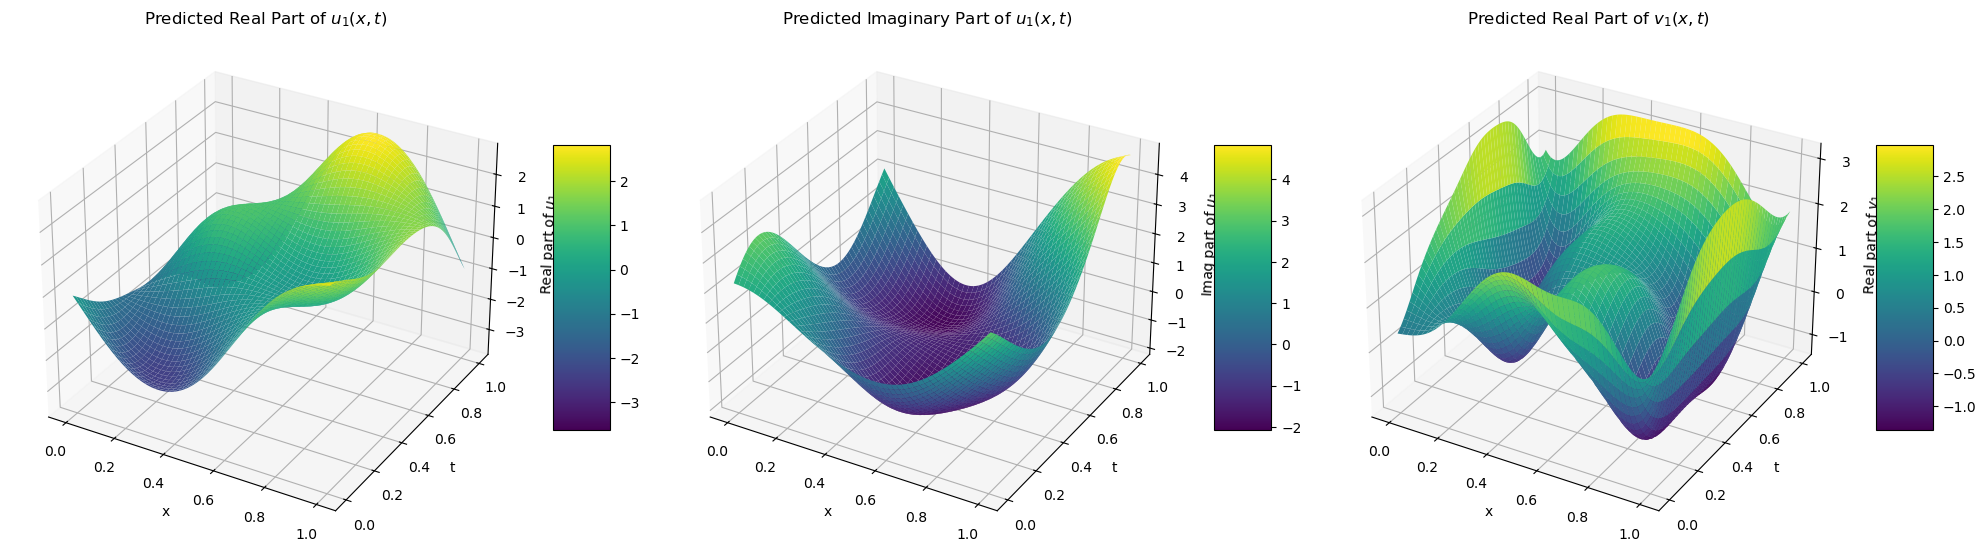

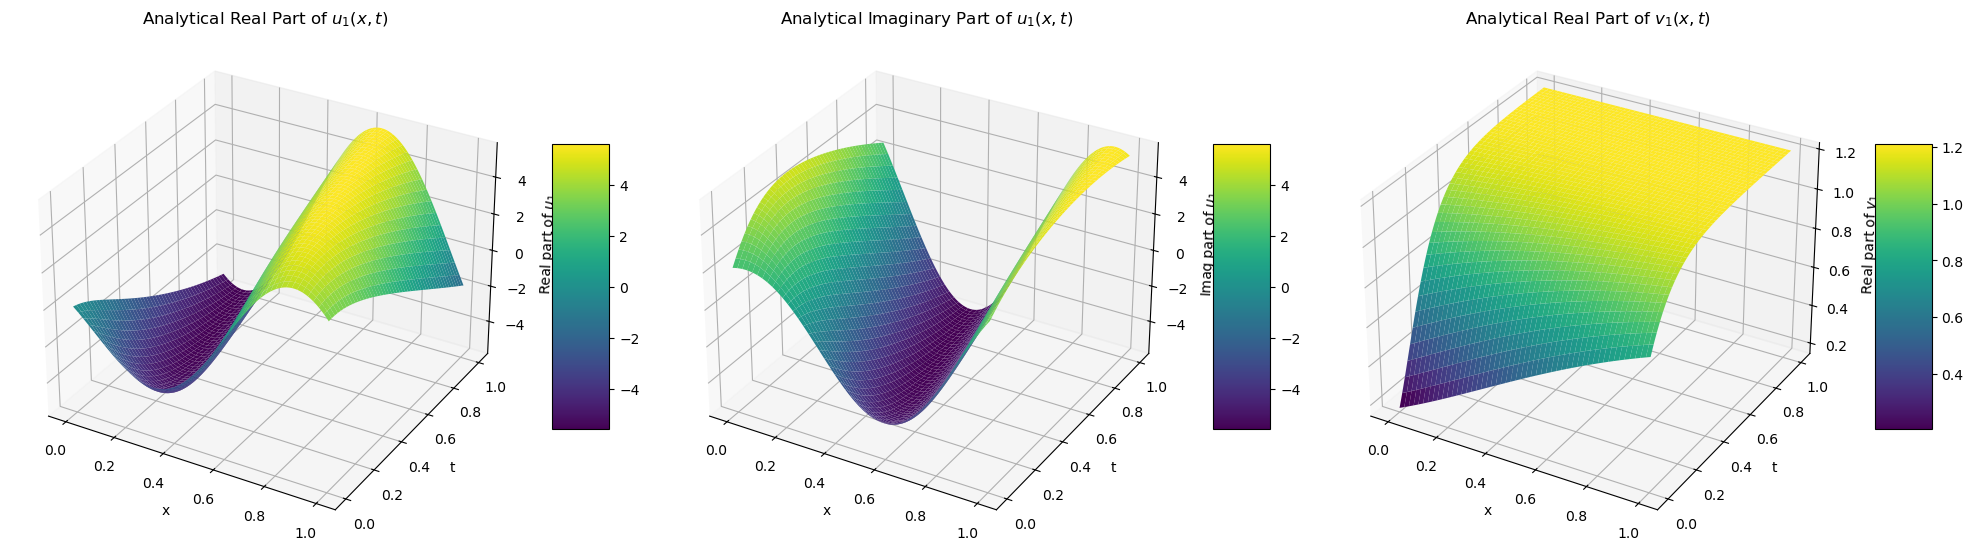

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a grid of x and t values
x = np.linspace(0, 1, 400)  # More points for a smoother plot
t = np.linspace(0, 1, 400)
X, T = np.meshgrid(x, t)
X_flat = X.flatten()
T_flat = T.flatten()

# Convert to torch tensors and prepare for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_t = torch.tensor(np.stack([X_flat, T_flat], axis=1), dtype=torch.float32).to(device)

# Assuming shared_model is defined and loaded with trained parameters
model_u1_state = torch.load(os.path.join(model_save_path, 'C_HIGGS_U1_epoch_99000.pth'), map_location=device)
model_v1_state = torch.load(os.path.join(model_save_path, 'C_HIGGS_V1_epoch_99000.pth'), map_location=device)
model_u1.load_state_dict(model_u1_state)
model_v1.load_state_dict(model_v1_state)
model_u1.eval()
model_v1.eval()
# Get predictions from the trained models
with torch.no_grad():
    #pred_u_r, pred_u_i, pred_v = shared_model(x_t)
    pred_u_r, pred_u_i = model_u1(x_t)
    pred_v = model_v1(x_t)
    pred_u_r = pred_u_r.cpu().numpy().reshape(X.shape)
    pred_u_i = pred_u_i.cpu().numpy().reshape(X.shape)
    pred_v = pred_v.cpu().numpy().reshape(X.shape)

# Calculate the analytical solutions
real_u1_analytical = real_u1(X, T, k, omega, r)
imag_u1_analytical = imag_u1(X, T, k, omega, r)
real_v1_analytical = real_v1(X, T, k, omega, r)

# Plotting
fig = plt.figure(figsize=(20, 6))

# Plot predicted and analytical real part of u1
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, T, pred_u_r, cmap='viridis')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
ax1.set_title('Predicted Real Part of $u_1(x, t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Real part of $u_1$')

# Plot predicted and analytical imaginary part of u1
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, T, pred_u_i, cmap='viridis')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
ax2.set_title('Predicted Imaginary Part of $u_1(x, t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Imag part of $u_1$')

# Plot predicted and analytical real part of v1
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, T, pred_v, cmap='viridis')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
ax3.set_title('Predicted Real Part of $v_1(x, t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Real part of $v_1$')

plt.tight_layout()
plt.show()

# Plotting
fig = plt.figure(figsize=(20, 6))

# Plot predicted and analytical real part of u1
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, T, real_u1_analytical, cmap='viridis')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
ax1.set_title('Analytical Real Part of $u_1(x, t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Real part of $u_1$')

# Plot predicted and analytical imaginary part of u1
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, T, imag_u1_analytical, cmap='viridis')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
ax2.set_title('Analytical Imaginary Part of $u_1(x, t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Imag part of $u_1$')

# Plot predicted and analytical real part of v1
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, T, real_v1_analytical, cmap='viridis')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
ax3.set_title('Analytical Real Part of $v_1(x, t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Real part of $v_1$')

plt.tight_layout()
plt.show()

